In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from tabulate import tabulate

import random
random.seed(123)

import json
import os

%run Code/plot_setup.py

%reload_ext autoreload
%autoreload 2

fig_path = "Figures_Plots/"

# Setup data

In [2]:
# change wd
cwd = os.getcwd()
os.chdir(cwd + "/Investment_Funnel_SOM")

from models.main import TradeBot

# setup funnel
algo = TradeBot()

# setup data

# full set
start = "2015-01-15"
end = "2022-11-24"
train_test_datesplit = "2019-01-01"

# SETUP WORKING DATASET,
algo.setup_data(
    start=start, 
    end=end, 
    train_test=True,  
    end_train = train_test_datesplit, 
    start_test = train_test_datesplit
)

# change wd back
os.chdir(cwd)

In [3]:
# etf symbols and names
with open("Data/Data_ETFs_Names.json", "r") as openfile:
    # Reading from json file
    etf_dict = json.load(openfile)
    
# benchmarks
with open("Data/Benchmarks.json", "r") as openfile:
    # Reading from json file
    nord_portfolios = json.load(openfile)
    
# Get Optimization data
with open("Data/Optimization_Results(Small).json", "r") as openfile:
    # Reading from json file
    small_opt_data = json.load(openfile)   
    
# Get Optimization data
with open("Data/Optimization_Results(Large).json", "r") as openfile:
    # Reading from json file
    large_opt_data = json.load(openfile)  

In [4]:
benchmarks = small_opt_data.get("benchmarks")


portfolio_data = {
    "Small Subset": small_opt_data.get("portfolios"),
    "Large Subset": large_opt_data.get("portfolios"),
}



date_index = small_opt_data.get("date_index")
date_index = [pd.Timestamp(d) for d in date_index]

period_index = np.arange(int(algo.lenTest/12))

In [5]:
new_keys = {
    'SOM-Cluster':'SOM-AHC', 
    'Cluster':'AHC', 
    'SOM-MST':'SOM-MST', 
    'MST':'MST',
    'nord_5':'NORD 5',
    'nord_13':'NORD 13',
    'nord_20':'NORD 20',
}

# Individual Optimal

## Small

In [6]:
subset_size = "Small Subset"

### Allocation

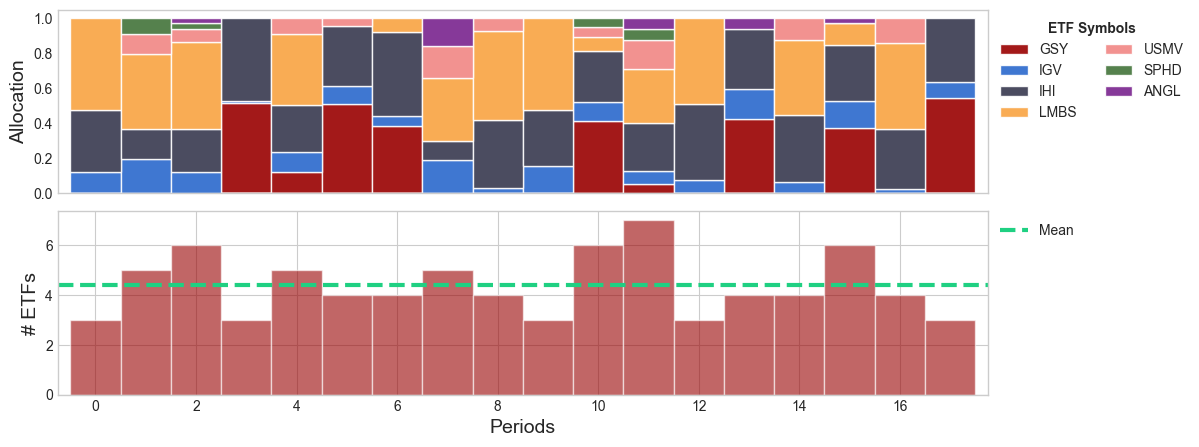

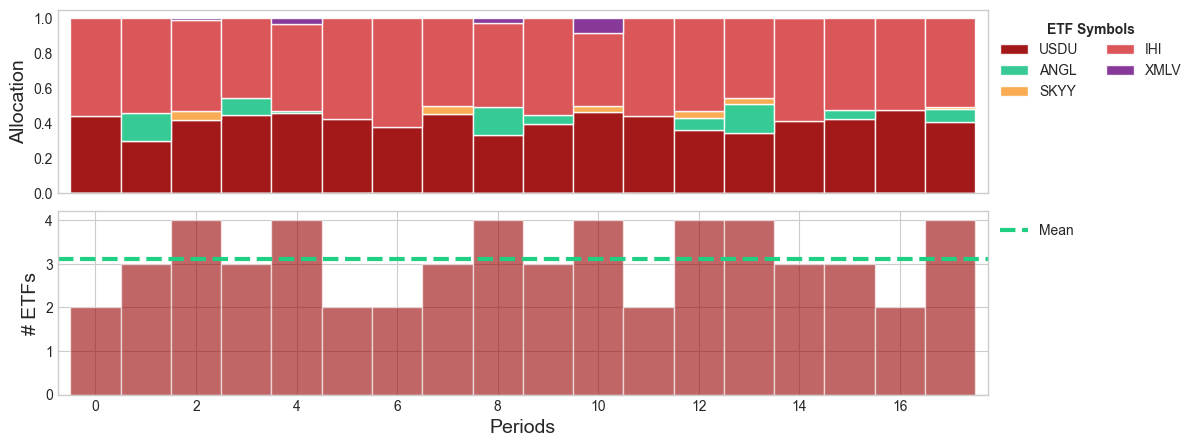

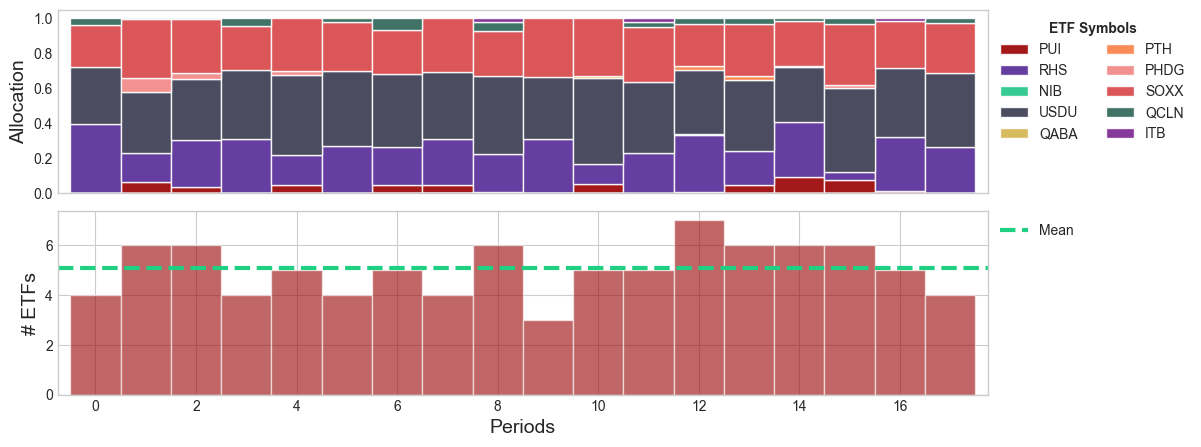

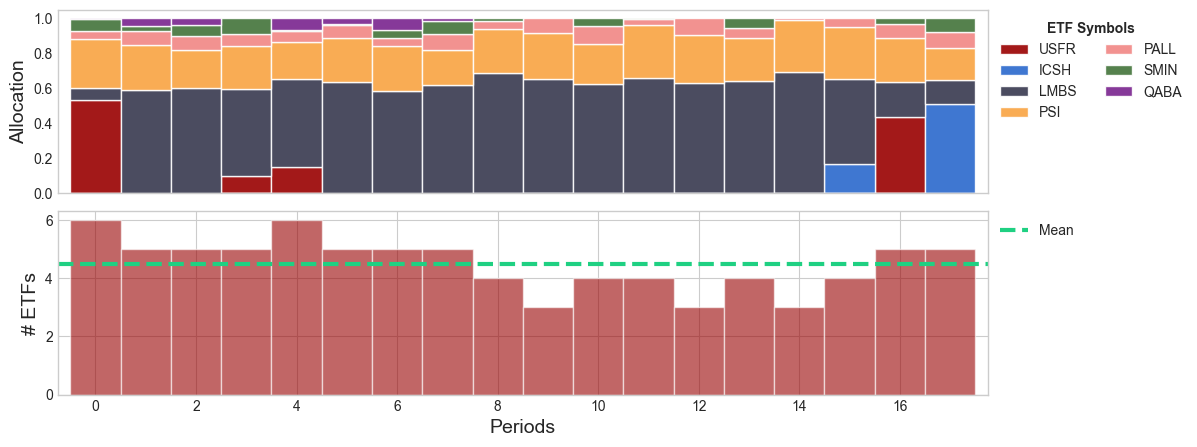

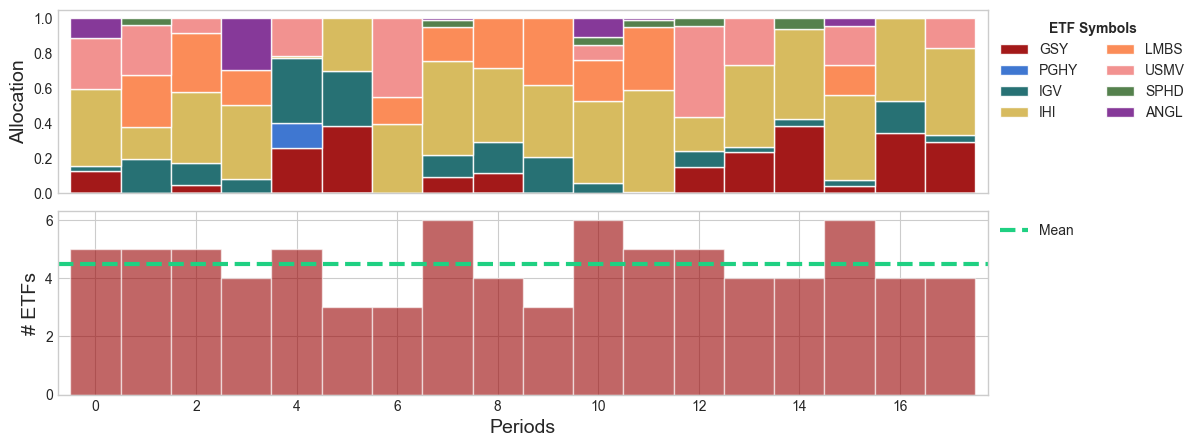

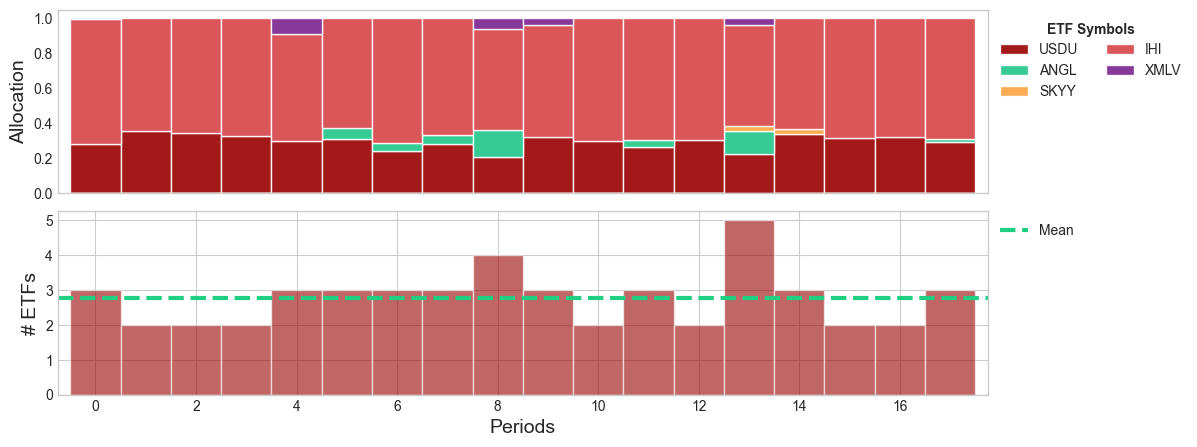

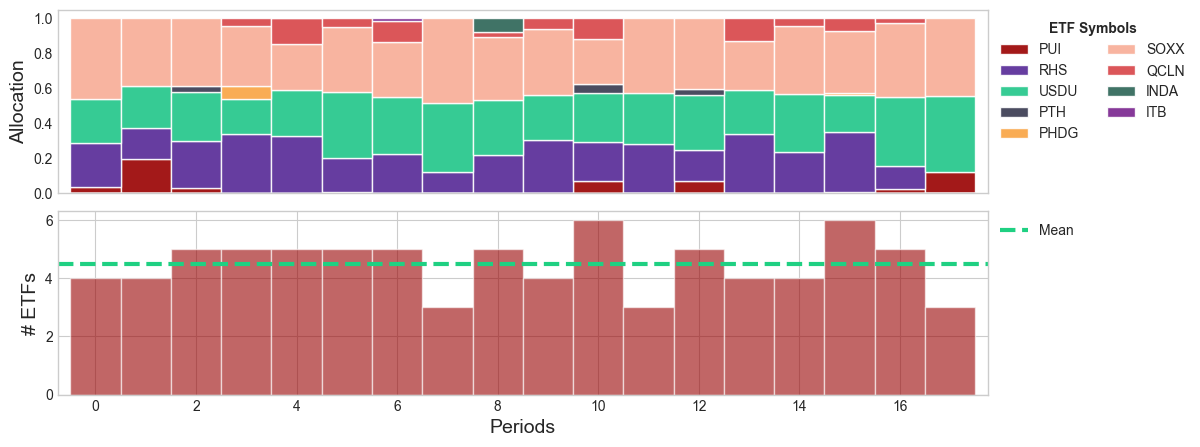

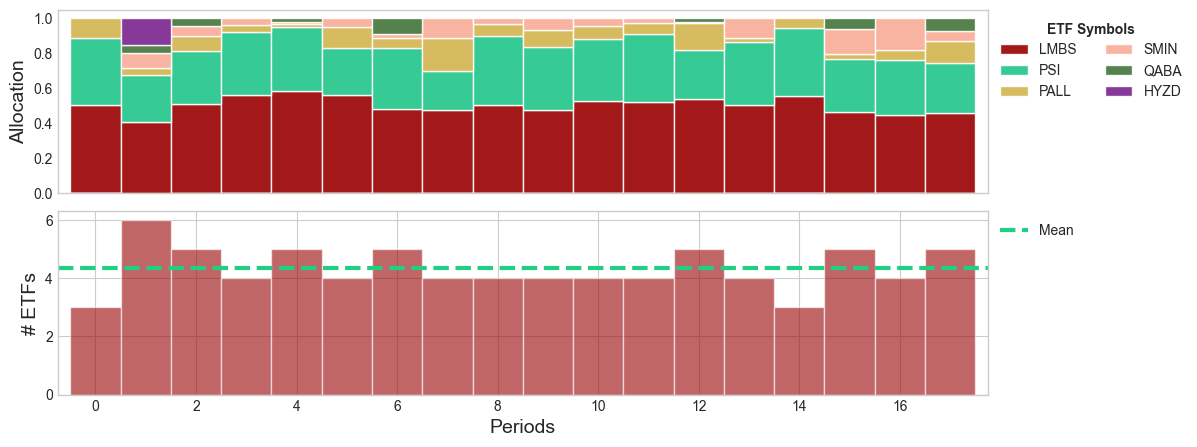

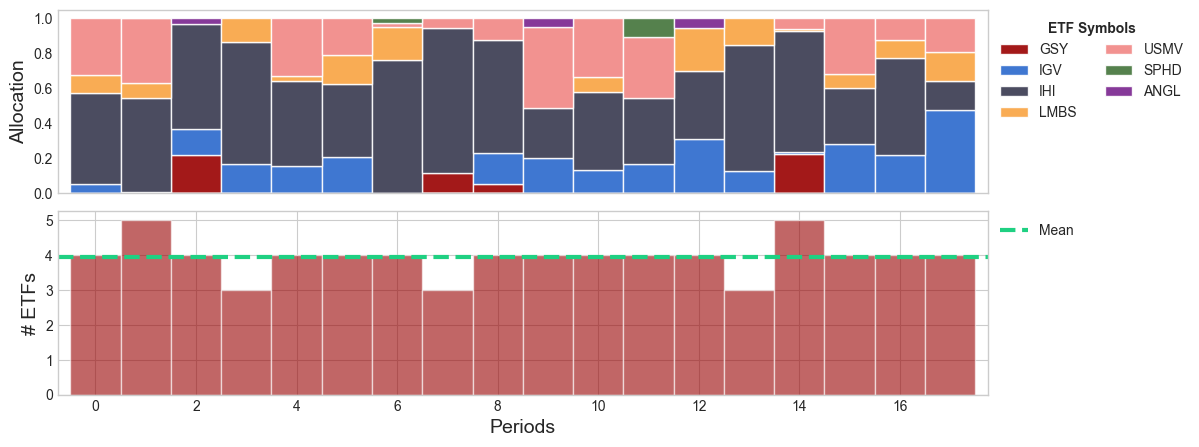

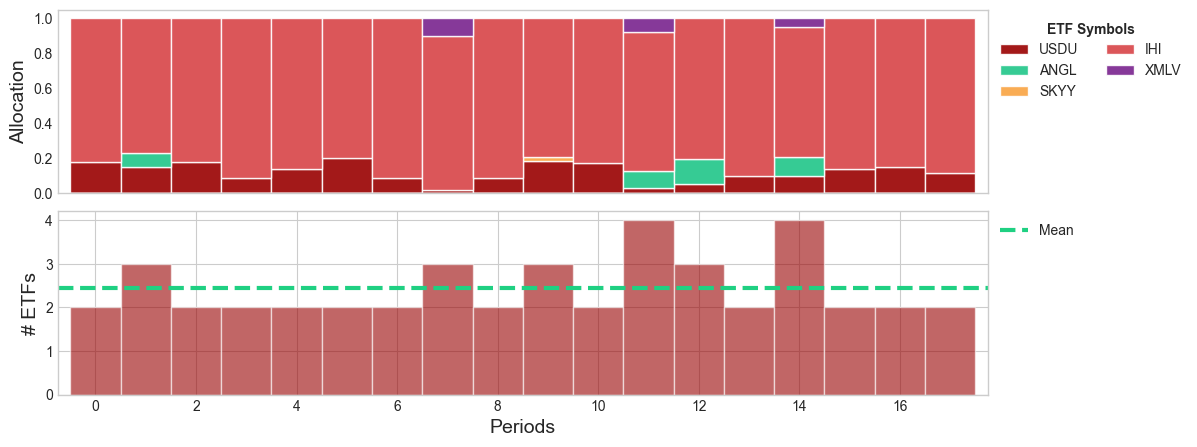

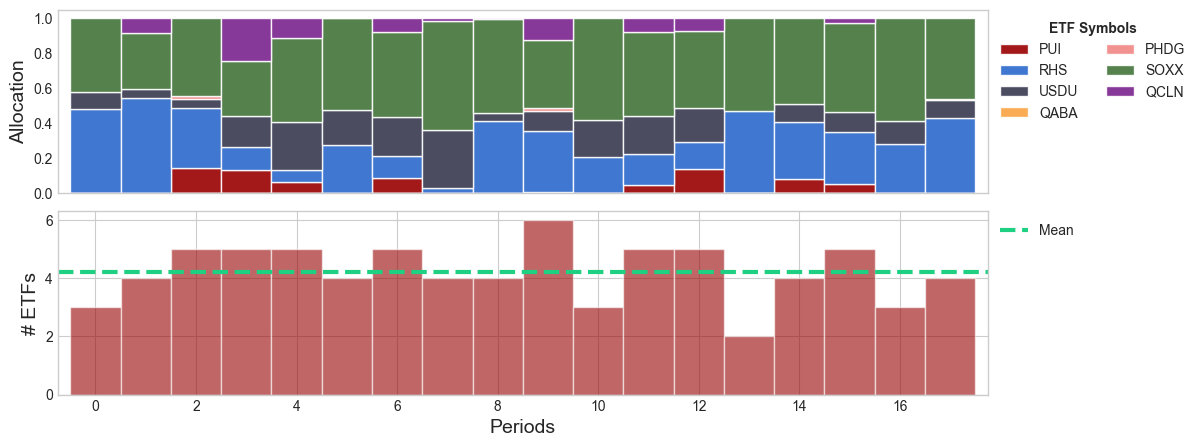

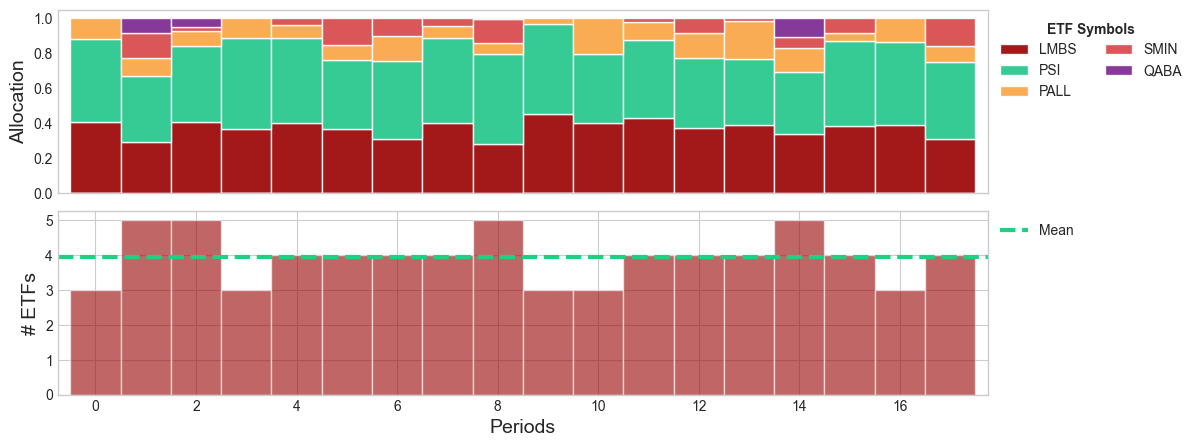

In [7]:

for level, level_item in portfolio_data[subset_size].items():
    
    for subset_name, item in level_item.items():
        fig = plt.figure(figsize=(12, 5))
        spec = fig.add_gridspec(
            2,1, 
            wspace = 0.15, 
            hspace = 0.10
        )
        

        ax = fig.add_subplot(spec[0])
        
        port_allocation = pd.DataFrame(item.get("allocation")).reset_index(drop = True)
        port_allocation = port_allocation.loc[:, port_allocation.sum() > 0]

        # plt.sca(ax)
        port_allocation.plot(kind = "bar", stacked = True, width = 1, alpha = 0.9, ax = ax, cmap = dtu_cmap_medium)
        plt.legend(ncol=2, loc='upper left', bbox_to_anchor=(1, 1), title = "ETF Symbols", title_fontproperties={'weight':'bold'},)
        plt.grid(False)
        #plt.xlabel("Periods")
        plt.ylabel("Allocation")
        #plt.xticks(np.arange(0, port_allocation.shape[0], 2), rotation = 0)
        plt.xticks([])
        #plt.title(subset_name + f" Optimal Portfolio ({subset_size})")
        # plt.tight_layout()
        # plt.show()

        
        
        ax = fig.add_subplot(spec[1])
        
        port_n_assets = (pd.DataFrame(item["allocation"]) > 0).sum(axis = 1)
        
        # plt.bar(x = np.arange(len(port_n_assets)), height = port_n_assets, width = 1, alpha = 0.6)
        port_n_assets.plot(kind = "bar", width = 1, alpha = 0.6, ax = ax)
        plt.axhline(y = np.mean(port_n_assets), color = colors["DTU Green"], label = "Mean", linestyle = "--")
        # plt.legend(loc='center left', bbox_to_anchor=(1, 0.50))
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        # plt.grid(False)
        plt.xlabel("Periods")
        plt.ylabel("# ETFs")
        plt.xticks(np.arange(0, port_allocation.shape[0], 2), rotation = 0)
        #plt.title(subset_name + " (Optimal Portfolio)")
        
        plt.savefig(fig_path + f'Optport_small_allocation_{level}_({subset_name}).png', bbox_inches='tight')
        plt.show()


        

### Insights

In [8]:
from Code.functions import get_stats, get_pdi, get_wpdi
from Code.functions import sharpe_ratio, starr_ratio
from Code.functions import get_annualized_returns, get_annualized_std

opt_stats = {}
opt_stats[subset_size] = {}
period_stats = {}
for level, level_item in portfolio_data[subset_size].items():
    opt_stats[subset_size][level] = {}
    period_stats[level] = {}
    
    for subset_name, item in level_item.items():
        
        # get stats
        port_value = pd.DataFrame({subset_name: item.get("value")}, index=date_index)
        port_returns = port_value.pct_change()[1:]
        
        opt_stats[subset_size][level][subset_name] = get_stats(port_returns)
        
        
        # get period data
        port_allocation = pd.DataFrame(item.get("allocation")).reset_index(drop = True)
        port_allocation = port_allocation.loc[:, port_allocation.sum() > 0] 

        port_period_stat = {
            "Period #Assets": [],
            "Period Returns (%)":[],
            "Std of Period Returns (%)":[],
            "Period PDI":[],
            "Period w.PDI":[],
        }
        for period in period_index:
            
            period_allocation = port_allocation.loc[period, port_allocation.loc[period, :] > 0]
            period_assets = period_allocation.index.to_list()

            # get returns
            period_returns = algo.testDataset.iloc[(period*12):((period + 1)*12), :]
            period_returns = period_returns.loc[:, period_assets]
            
            # period_returns = period_returns.iloc[-12:, :]
            period_port_returns = pd.DataFrame(period_returns @ period_allocation)
            
            period_pdi = get_pdi(period_returns)
            period_wpdi = get_wpdi(period_returns, period_allocation.values)
            
            period_sharpe = sharpe_ratio(period_port_returns, "weekly")[0]
            period_starr = starr_ratio(period_port_returns, "weekly")[0]
            
            period_return = np.cumprod(1 + period_port_returns.values)[-1] - 1
            period_std = np.std(period_port_returns.values)
            
            port_period_stat["Period #Assets"].append(len(period_assets))
            
            port_period_stat["Period PDI"].append(period_pdi)
            port_period_stat["Period w.PDI"].append(period_wpdi)
            
            port_period_stat["Period Returns (%)"].append(period_return * 100)
            # port_period_stat["Period Std of Returns (%)"].append(period_std * 100)

            
        # store period data
        port_period_stat["Std of Period Returns (%)"].append(np.std(port_period_stat["Period Returns (%)"]))
        period_stats[level][subset_name] = port_period_stat
           
    # get period data for benchmark
    port_period_stat = {
        "Period #Assets": [],
        "Period Returns (%)":[],
        "Std of Period Returns (%)":[],
        "Period PDI":[],
        "Period w.PDI":[],
    }
    for period in period_index:

        period_allocation = np.array(nord_portfolios[level]["weights"])
        period_assets = nord_portfolios[level]["symbols"]

        # get returns
        period_returns = algo.testDataset.iloc[(period*12):((period + 1)*12), :]
        period_returns = period_returns.loc[:, period_assets]

        # period_returns = period_returns.iloc[-12:, :]
        period_port_returns = pd.DataFrame(period_returns @ period_allocation)

        period_pdi = get_pdi(period_returns)
        period_wpdi = get_wpdi(period_returns, period_allocation)

        period_sharpe = sharpe_ratio(period_port_returns, "weekly")[0]
        period_starr = starr_ratio(period_port_returns, "weekly")[0]

        period_return = np.cumprod(1 + period_port_returns.values)[-1] - 1
        period_std = np.std(period_port_returns.values)
        
        port_period_stat["Period #Assets"].append(len(period_assets))
        
        port_period_stat["Period PDI"].append(period_pdi)
        port_period_stat["Period w.PDI"].append(period_wpdi)

        port_period_stat["Period Returns (%)"].append(period_return * 100)
        #port_period_stat["Period Std of Returns (%)"].append(period_std * 100)
    
    
    # store period data for benchmark
    port_period_stat["Std of Period Returns (%)"].append(np.std(port_period_stat["Period Returns (%)"]))
    period_stats[level][level] = port_period_stat
    
    # get benchmark stats
    benchmark_value = pd.DataFrame({level: benchmarks[level].get("value")}, index=date_index)
    benchmark_returns = benchmark_value.pct_change()[1:]
    
    opt_stats[subset_size][level][level] = get_stats(benchmark_returns)


In [9]:
port_summary_tab = {}
for level, level_item in opt_stats[subset_size].items():
    
    opt_tab = pd.DataFrame(level_item)
    
    mean_period_tab = pd.DataFrame(period_stats[level]).applymap(np.mean)
    mean_period_tab.index = ["Avg. " + i if i != "Std of Period Returns (%)" else i for i in mean_period_tab.index]
    
    port_summary_tab[level] = pd.concat([opt_tab, mean_period_tab])
    
for level, tab in port_summary_tab.items():
    print(f"Table for: {level} ({subset_size})\n")
    print(tabulate(tab, headers = "keys", floatfmt = "0.2f", tablefmt = "latex"))
    print(f"\n\n")

Table for: nord_5 (Small Subset)

\begin{tabular}{lrrrrr}
\hline
                           &   SOM-Cluster &   Cluster &   SOM-MST &   MST &   nord\_5 \\
\hline
 Weekly mean Returns (\%)   &          0.13 &      0.17 &      0.27 &  0.19 &     0.10 \\
 Std of Weekly Returns (\%) &          1.59 &      1.56 &      1.62 &  1.63 &     1.29 \\
 Annualized Returns (\%)    &          6.36 &      8.75 &     14.44 &  9.89 &     4.68 \\
 Annualized Std (\%)        &         11.44 &     11.23 &     11.71 & 11.74 &     9.32 \\
 Sharpe Ratio              &          0.56 &      0.78 &      1.23 &  0.84 &     0.50 \\
 Starr Ratio               &          1.53 &      2.34 &      4.01 &  2.67 &     1.43 \\
 CVaR (\%)                  &         -4.17 &     -3.75 &     -3.60 & -3.71 &    -3.26 \\
 Avg. Period \#Assets       &          4.47 &      3.06 &      5.12 &  4.47 &     7.00 \\
 Avg. Period Returns (\%)   &          1.64 &      2.06 &      3.35 &  2.42 &     1.19 \\
 Std of Period Returns (\%) & 

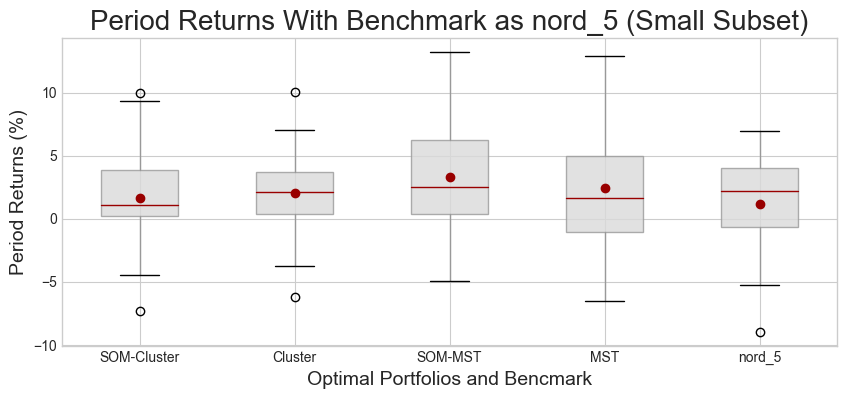

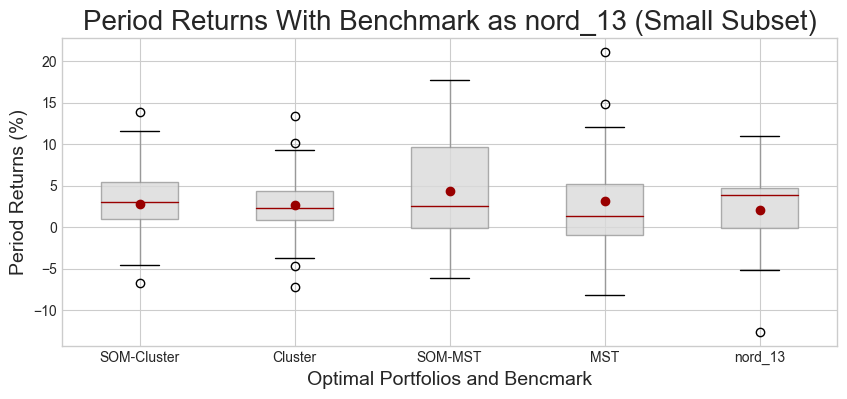

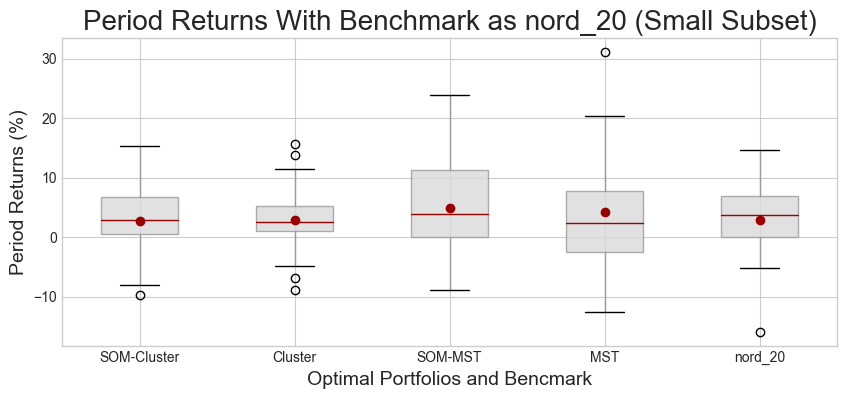

In [10]:
tmp = {}
for level, level_item in period_stats.items():
    tmp[level] = {}
    for port, item in level_item.items():
        tmp[level][port] = item["Period Returns (%)"]
        
    fig, ax = plt.subplots()
    meanprops = dict(marker='o', markerfacecolor = colors["DTU Red"], markeredgecolor = colors["DTU Red"])
    ax, props  = pd.DataFrame(tmp[level]).boxplot(
        showfliers=True,
        medianprops=dict(color = colors["DTU Red"]),
        showmeans=True, meanline=False, meanprops=meanprops,
        patch_artist=True,
        return_type='both', ax=ax
    )
    for patch in props['boxes']:
        patch.set_facecolor(colors["DTU Gray"])
        patch.set_alpha(0.8)

    plt.ylabel("Period Returns (%)")
    plt.xlabel("Optimal Portfolios and Bencmark")
    plt.title(f"Period Returns With Benchmark as {level} ({subset_size})")
    
    plt.savefig(fig_path + f'Optport_small_returns_{level}.png', bbox_inches='tight')
    plt.show()

## Large

In [11]:
subset_size = "Large Subset"

### Allocation

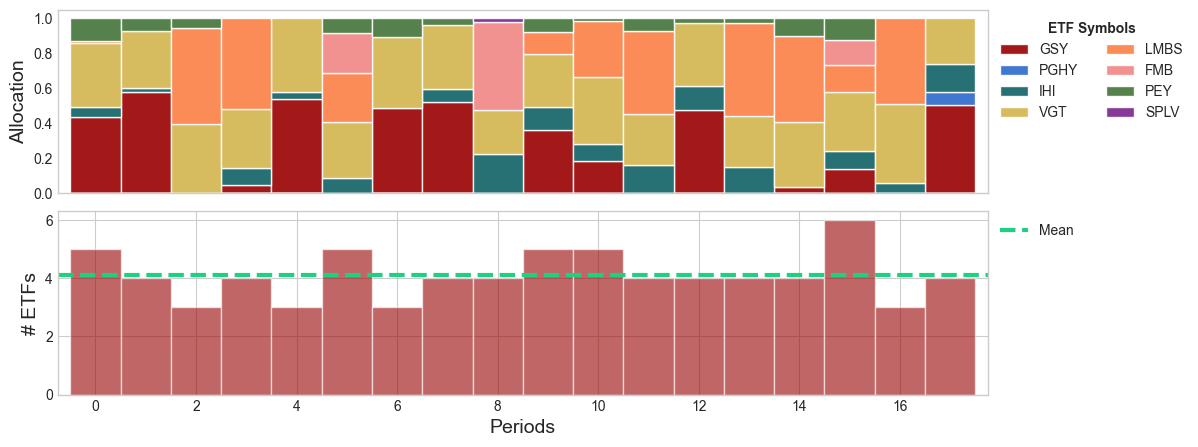

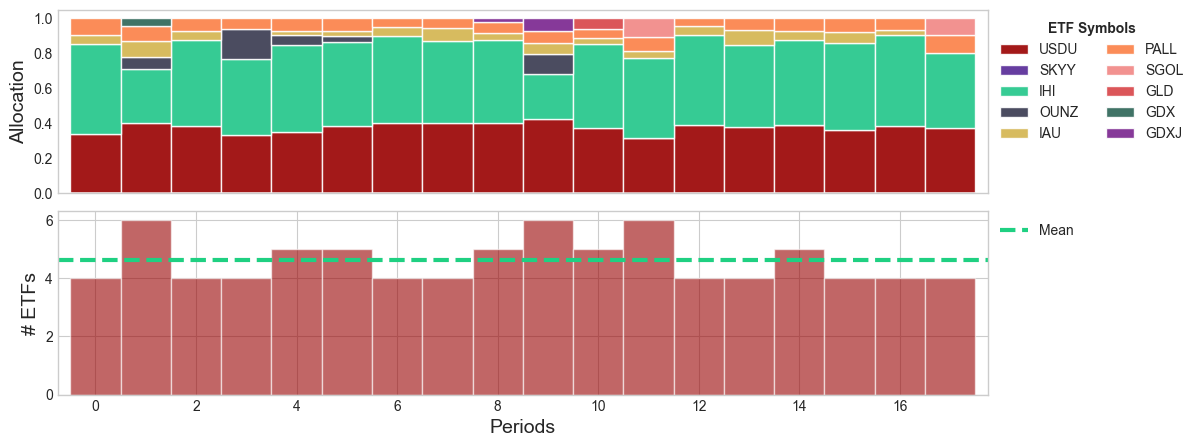

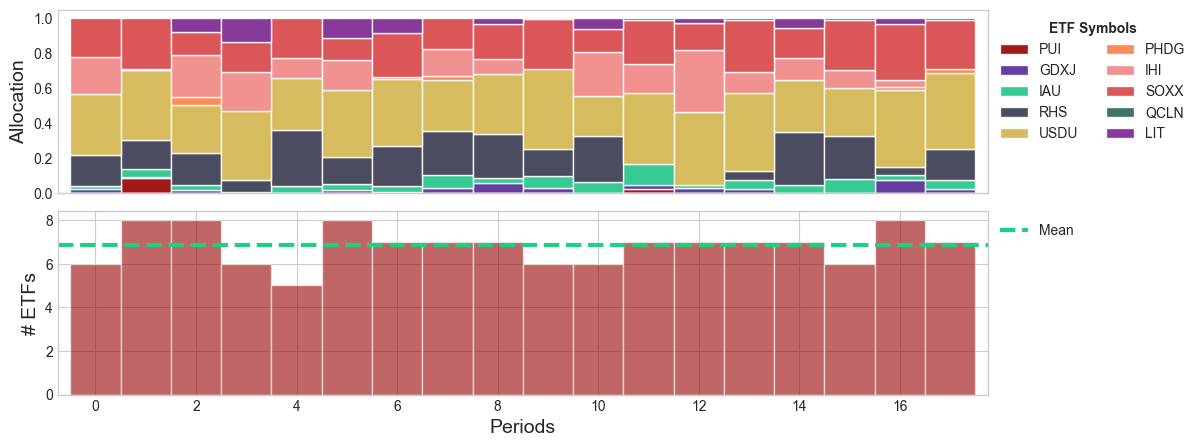

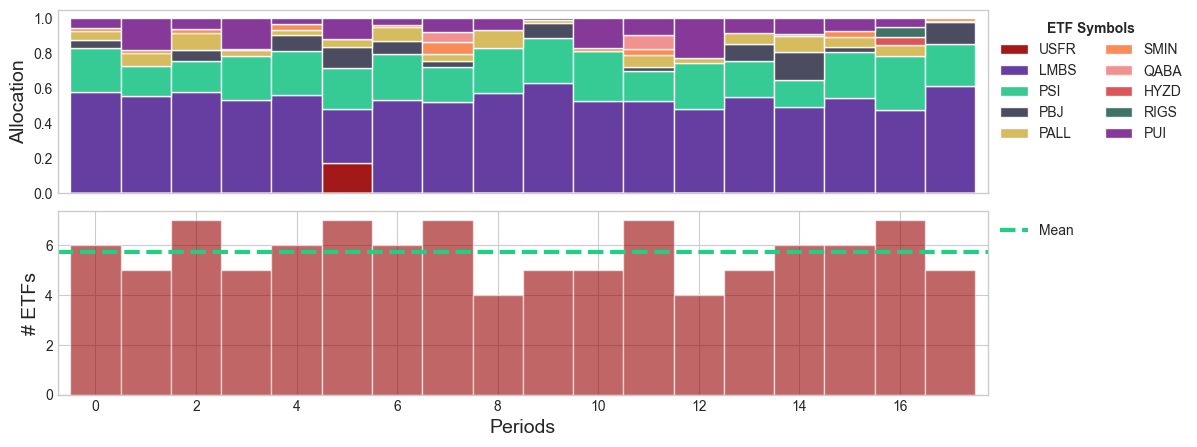

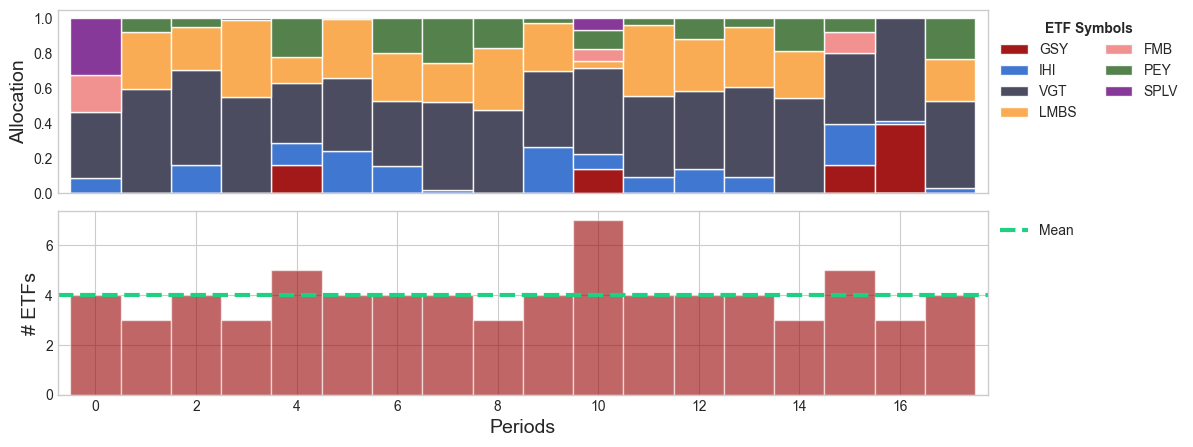

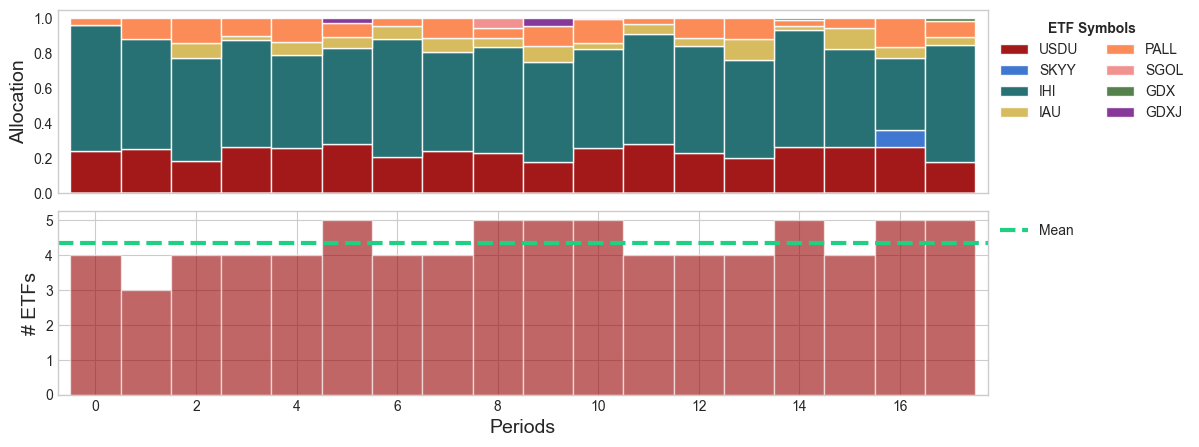

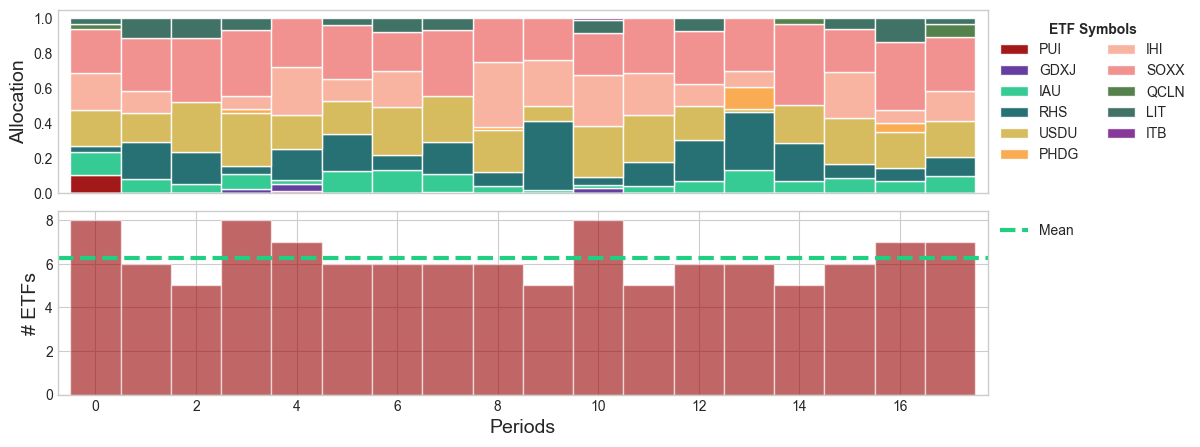

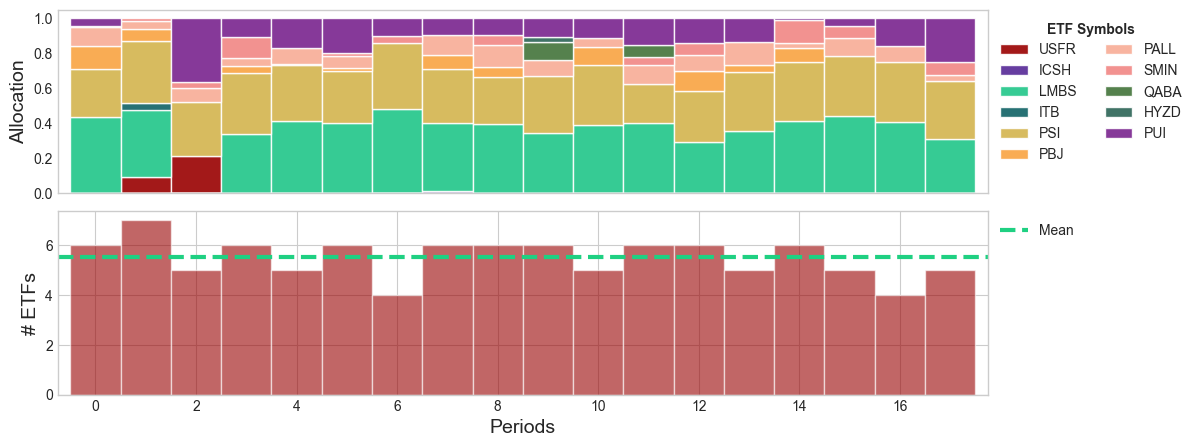

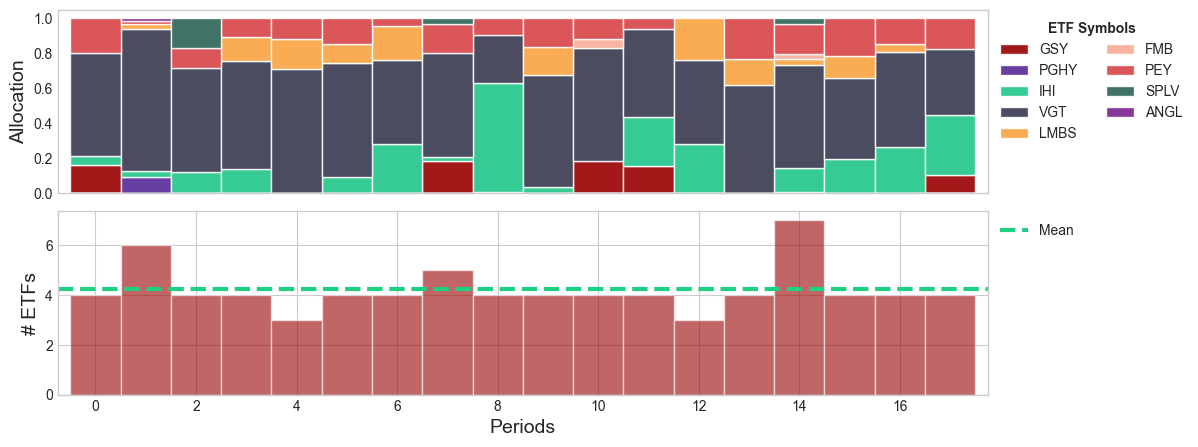

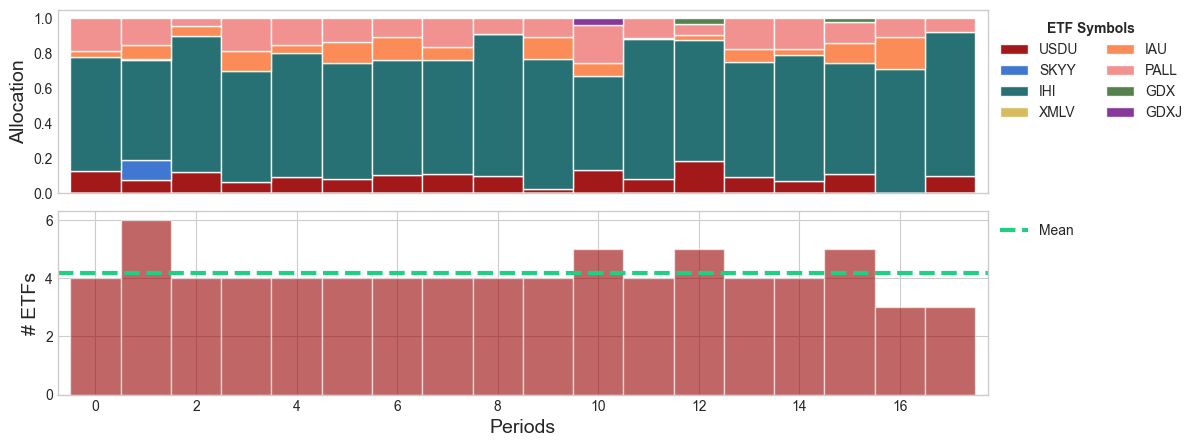

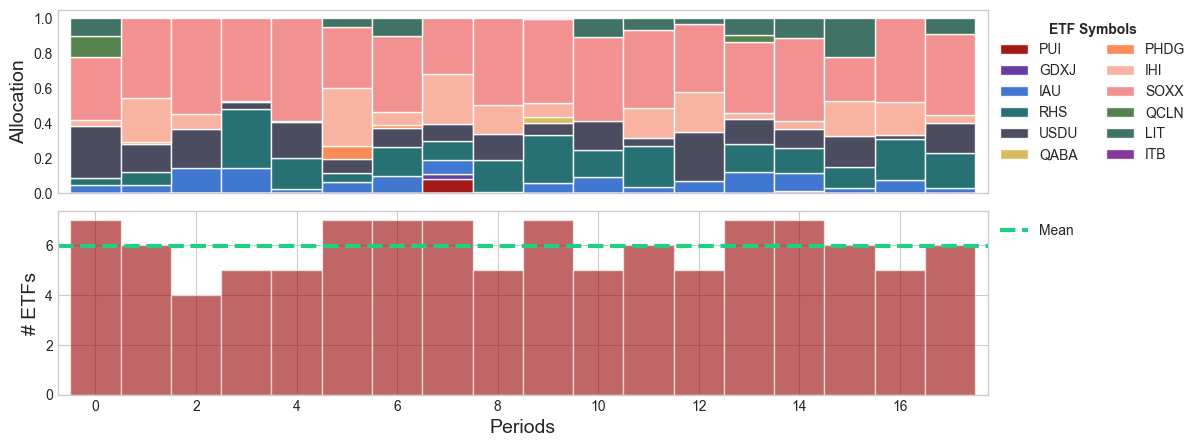

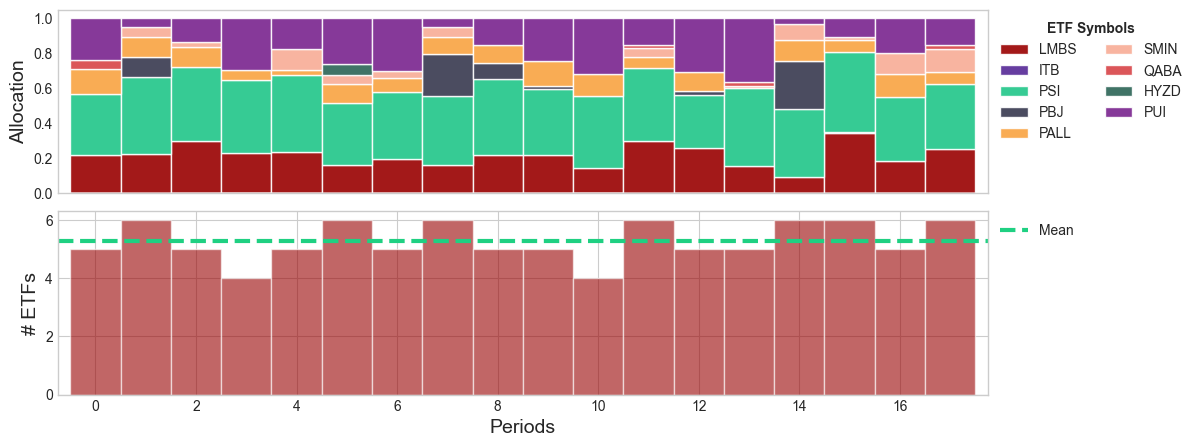

In [12]:


for level, level_item in portfolio_data[subset_size].items():
    
    for subset_name, item in level_item.items():
        fig = plt.figure(figsize=(12, 5))
        spec = fig.add_gridspec(
            2,1, 
            wspace = 0.15, 
            hspace = 0.10
        )
        

        ax = fig.add_subplot(spec[0])
        
        port_allocation = pd.DataFrame(item.get("allocation")).reset_index(drop = True)
        port_allocation = port_allocation.loc[:, port_allocation.sum() > 0]

        # plt.sca(ax)
        port_allocation.plot(kind = "bar", stacked = True, width = 1, alpha = 0.9, ax = ax, cmap = dtu_cmap_medium)
        plt.legend(ncol=2, loc='upper left', bbox_to_anchor=(1, 1), title = "ETF Symbols", title_fontproperties={'weight':'bold'},)
        plt.grid(False)
        #plt.xlabel("Periods")
        plt.ylabel("Allocation")
        #plt.xticks(np.arange(0, port_allocation.shape[0], 2), rotation = 0)
        plt.xticks([])
        #plt.title(subset_name + f" Optimal Portfolio ({subset_size})")
        # plt.tight_layout()
        # plt.show()

        
        
        ax = fig.add_subplot(spec[1])
        
        port_n_assets = (pd.DataFrame(item["allocation"]) > 0).sum(axis = 1)
        
        # plt.bar(x = np.arange(len(port_n_assets)), height = port_n_assets, width = 1, alpha = 0.6)
        port_n_assets.plot(kind = "bar", width = 1, alpha = 0.6, ax = ax)
        plt.axhline(y = np.mean(port_n_assets), color = colors["DTU Green"], label = "Mean", linestyle = "--")
        # plt.legend(loc='center left', bbox_to_anchor=(1, 0.50))
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        # plt.grid(False)
        plt.xlabel("Periods")
        plt.ylabel("# ETFs")
        plt.xticks(np.arange(0, port_allocation.shape[0], 2), rotation = 0)
        #plt.title(subset_name + " (Optimal Portfolio)")
        
        plt.savefig(fig_path + f'Optport_large_allocation_{level}_({subset_name}).png', bbox_inches='tight')
        plt.show()


        

### Insights

In [13]:
from Code.functions import get_stats, get_pdi, get_wpdi
from Code.functions import sharpe_ratio, starr_ratio
from Code.functions import get_annualized_returns, get_annualized_std


opt_stats[subset_size] = {}
period_stats = {}
for level, level_item in portfolio_data[subset_size].items():
    opt_stats[subset_size][level] = {}
    period_stats[level] = {}
    
    for subset_name, item in level_item.items():
        
        # get stats
        port_value = pd.DataFrame({subset_name: item.get("value")}, index=date_index)
        port_returns = port_value.pct_change()[1:]
        
        opt_stats[subset_size][level][subset_name] = get_stats(port_returns)
        
        
        # get period data
        port_allocation = pd.DataFrame(item.get("allocation")).reset_index(drop = True)
        port_allocation = port_allocation.loc[:, port_allocation.sum() > 0] 

        port_period_stat = {
            "Period #Assets": [],
            "Period Returns (%)":[],
            "Std of Period Returns (%)":[],
            "Period PDI":[],
            "Period w.PDI":[],
        }
        for period in period_index:
            
            period_allocation = port_allocation.loc[period, port_allocation.loc[period, :] > 0]
            period_assets = period_allocation.index.to_list()

            # get returns
            period_returns = algo.testDataset.iloc[(period*12):((period + 1)*12), :]
            period_returns = period_returns.loc[:, period_assets]
            
            # period_returns = period_returns.iloc[-12:, :]
            period_port_returns = pd.DataFrame(period_returns @ period_allocation)
            
            period_pdi = get_pdi(period_returns)
            period_wpdi = get_wpdi(period_returns, period_allocation.values)
            
            period_sharpe = sharpe_ratio(period_port_returns, "weekly")[0]
            period_starr = starr_ratio(period_port_returns, "weekly")[0]
            
            period_return = np.cumprod(1 + period_port_returns.values)[-1] - 1
            period_std = np.std(period_port_returns.values)
            
            port_period_stat["Period #Assets"].append(len(period_assets))
            
            port_period_stat["Period PDI"].append(period_pdi)
            port_period_stat["Period w.PDI"].append(period_wpdi)
            
            port_period_stat["Period Returns (%)"].append(period_return * 100)
            # port_period_stat["Period Std of Returns (%)"].append(period_std * 100)

            
        # store period data
        port_period_stat["Std of Period Returns (%)"].append(np.std(port_period_stat["Period Returns (%)"]))
        period_stats[level][subset_name] = port_period_stat
           
    # get period data for benchmark
    port_period_stat = {
        "Period #Assets": [],
        "Period Returns (%)":[],
        "Std of Period Returns (%)":[],
        "Period PDI":[],
        "Period w.PDI":[],
    }
    for period in period_index:

        period_allocation = np.array(nord_portfolios[level]["weights"])
        period_assets = nord_portfolios[level]["symbols"]

        # get returns
        period_returns = algo.testDataset.iloc[(period*12):((period + 1)*12), :]
        period_returns = period_returns.loc[:, period_assets]

        # period_returns = period_returns.iloc[-12:, :]
        period_port_returns = pd.DataFrame(period_returns @ period_allocation)

        period_pdi = get_pdi(period_returns)
        period_wpdi = get_wpdi(period_returns, period_allocation)

        period_sharpe = sharpe_ratio(period_port_returns, "weekly")[0]
        period_starr = starr_ratio(period_port_returns, "weekly")[0]

        period_return = np.cumprod(1 + period_port_returns.values)[-1] - 1
        period_std = np.std(period_port_returns.values)
        
        port_period_stat["Period #Assets"].append(len(period_assets))
        
        port_period_stat["Period PDI"].append(period_pdi)
        port_period_stat["Period w.PDI"].append(period_wpdi)

        port_period_stat["Period Returns (%)"].append(period_return * 100)
        #port_period_stat["Period Std of Returns (%)"].append(period_std * 100)
    
    
    # store period data for benchmark
    port_period_stat["Std of Period Returns (%)"].append(np.std(port_period_stat["Period Returns (%)"]))
    period_stats[level][level] = port_period_stat
    
    # get benchmark stats
    benchmark_value = pd.DataFrame({level: benchmarks[level].get("value")}, index=date_index)
    benchmark_returns = benchmark_value.pct_change()[1:]
    
    opt_stats[subset_size][level][level] = get_stats(benchmark_returns)


In [14]:
port_summary_tab = {}
for level, level_item in opt_stats[subset_size].items():
    
    opt_tab = pd.DataFrame(level_item)
    
    mean_period_tab = pd.DataFrame(period_stats[level]).applymap(np.mean)
    mean_period_tab.index = ["Avg. " + i if i != "Std of Period Returns (%)" else i for i in mean_period_tab.index]
    
    port_summary_tab[level] = pd.concat([opt_tab, mean_period_tab])
    
for level, tab in port_summary_tab.items():
    print(f"Table for: {level} ({subset_size})\n")
    print(tabulate(tab, headers = "keys", floatfmt = "0.2f", tablefmt = "latex"))
    print(f"\n\n")

Table for: nord_5 (Large Subset)

\begin{tabular}{lrrrrr}
\hline
                           &   SOM-Cluster &   Cluster &   SOM-MST &   MST &   nord\_5 \\
\hline
 Weekly mean Returns (\%)   &          0.19 &      0.18 &      0.27 &  0.20 &     0.10 \\
 Std of Weekly Returns (\%) &          1.66 &      1.56 &      1.73 &  1.66 &     1.29 \\
 Annualized Returns (\%)    &          9.52 &      9.37 &     14.13 &  9.99 &     4.68 \\
 Annualized Std (\%)        &         11.96 &     11.22 &     12.46 & 12.00 &     9.32 \\
 Sharpe Ratio              &          0.80 &      0.84 &      1.13 &  0.83 &     0.50 \\
 Starr Ratio               &          2.22 &      2.41 &      3.31 &  2.40 &     1.43 \\
 CVaR (\%)                  &         -4.30 &     -3.89 &     -4.27 & -4.16 &    -3.26 \\
 Avg. Period \#Assets       &          4.12 &      4.65 &      6.82 &  5.76 &     7.00 \\
 Avg. Period Returns (\%)   &          2.38 &      2.23 &      3.32 &  2.44 &     1.19 \\
 Std of Period Returns (\%) & 

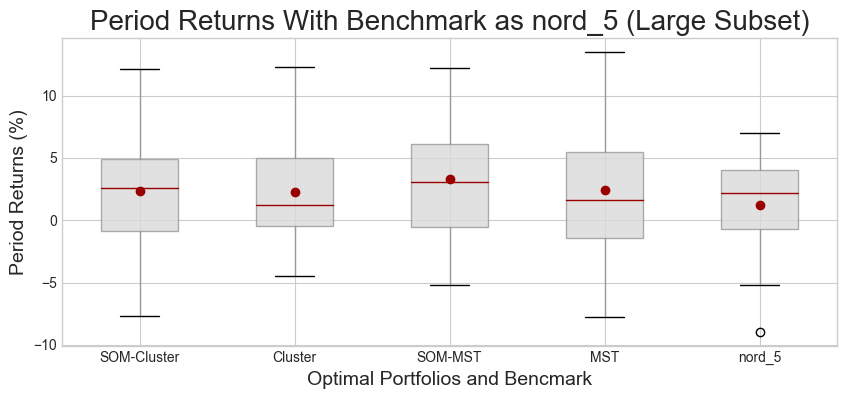

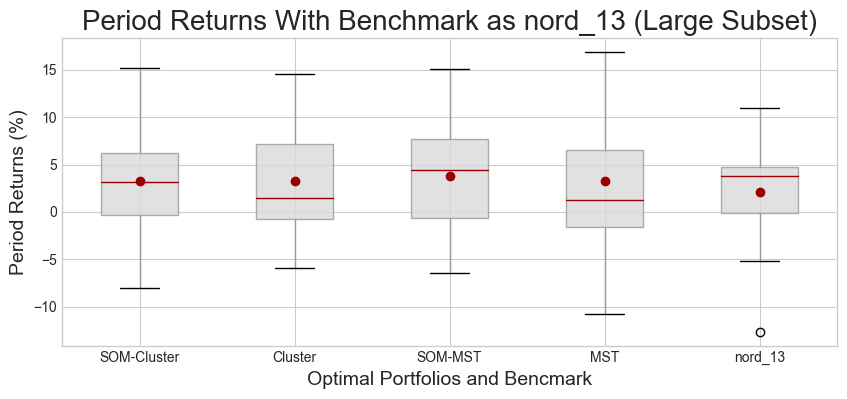

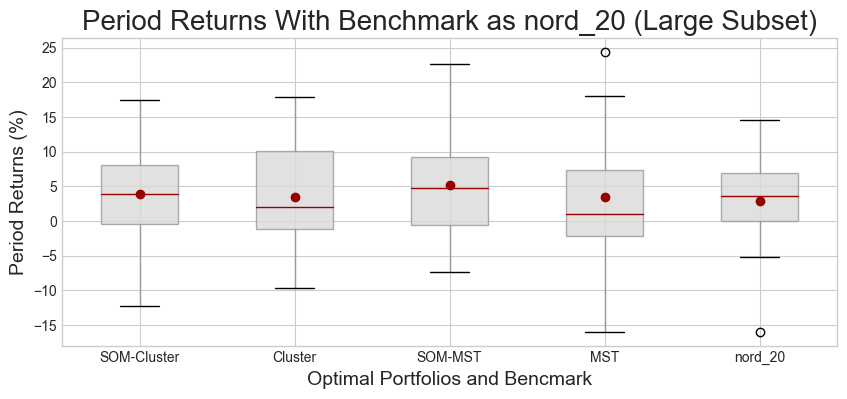

In [15]:
tmp = {}
for level, level_item in period_stats.items():
    tmp[level] = {}
    for port, item in level_item.items():
        tmp[level][port] = item["Period Returns (%)"]
        
    fig, ax = plt.subplots()
    meanprops = dict(marker='o', markerfacecolor = colors["DTU Red"], markeredgecolor = colors["DTU Red"])
    ax, props  = pd.DataFrame(tmp[level]).boxplot(
        showfliers=True,
        medianprops=dict(color = colors["DTU Red"]),
        showmeans=True, meanline=False, meanprops=meanprops,
        patch_artist=True,
        return_type='both', ax=ax
    )
    for patch in props['boxes']:
        patch.set_facecolor(colors["DTU Gray"])
        patch.set_alpha(0.8)

    plt.ylabel("Period Returns (%)")
    plt.xlabel("Optimal Portfolios and Bencmark")
    plt.title(f"Period Returns With Benchmark as {level} ({subset_size})")
    
    plt.savefig(fig_path + f'Optport_large_returns_{level}.png', bbox_inches='tight')
    plt.show()

# Comparing Methods

## ALL

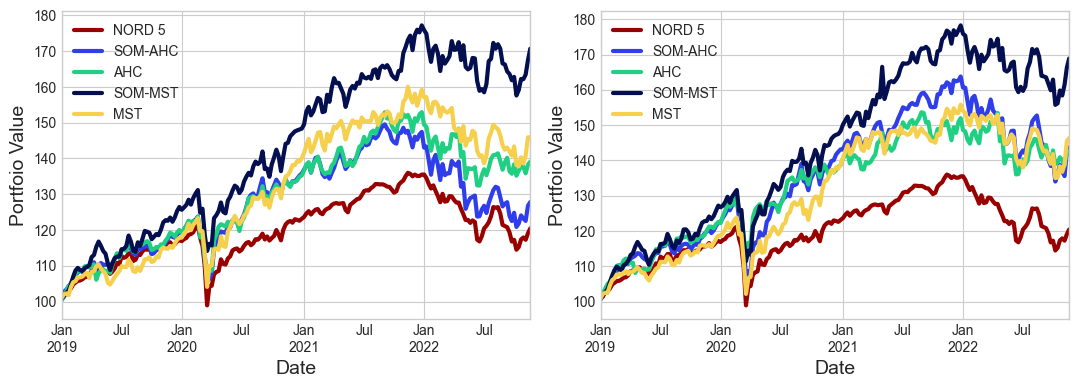

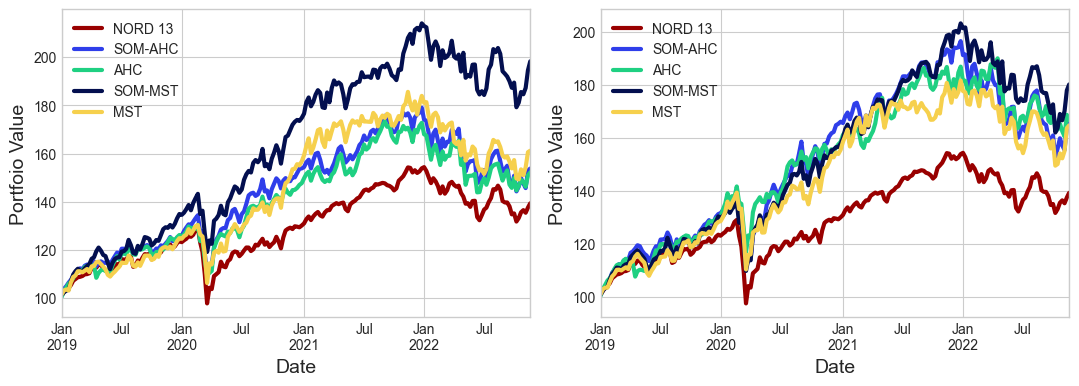

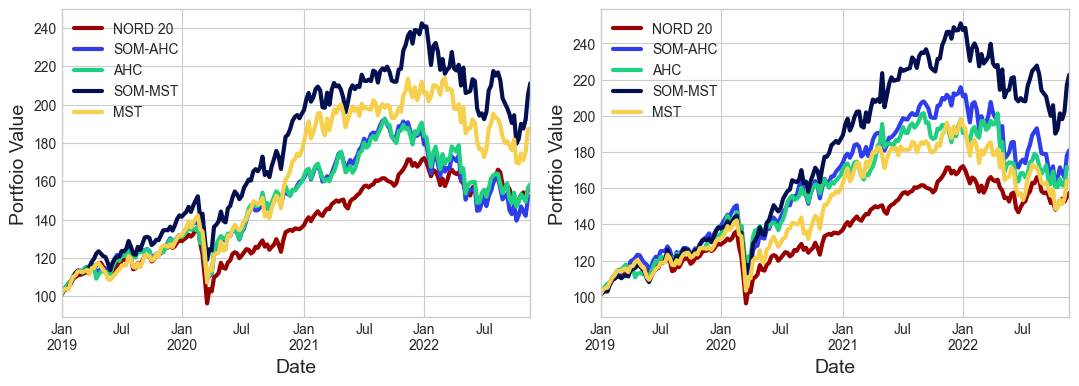

In [16]:
for level, level_item in benchmarks.items():
    
    
    fig = plt.figure(figsize=(13, 4))
    spec = fig.add_gridspec(
        1,2, 
        wspace = 0.15, 
        hspace=0.05
    )


    # small
    portfolio_values = pd.DataFrame({
        new_keys[level]: level_item["value"]
    }, index = date_index)


    for subset_name, item in portfolio_data["Small Subset"][level].items():
        portfolio_values[new_keys[subset_name]] = item.get("value")
        
    ax = fig.add_subplot(spec[0])
    portfolio_values.plot(ax=ax)
    plt.ylabel("Portfoio Value")
    plt.xlabel("Date")
    #plt.title("Small Subset", size = 15, alpha = 0.6)
    
    # large
    portfolio_values = pd.DataFrame({
        new_keys[level]: level_item["value"]
    }, index = date_index)


    for subset_name, item in portfolio_data["Large Subset"][level].items():
        portfolio_values[new_keys[subset_name]] = item.get("value")
        
    ax = fig.add_subplot(spec[1])
    portfolio_values.plot(ax=ax)
    plt.ylabel("Portfoio Value")
    plt.xlabel("Date")
    #plt.title("Large Subset", size = 15, alpha = 0.6)

    #plt.suptitle(f"Portfolio Value Comparison ({level})", size = 20, y=1.05)
    
    plt.savefig(fig_path + f'Optport_both_value_{level}.png', bbox_inches='tight')
    plt.show()
    

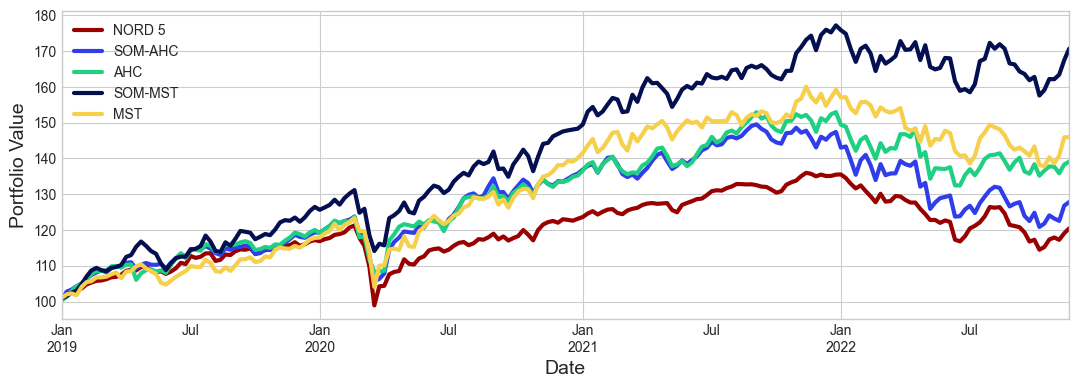

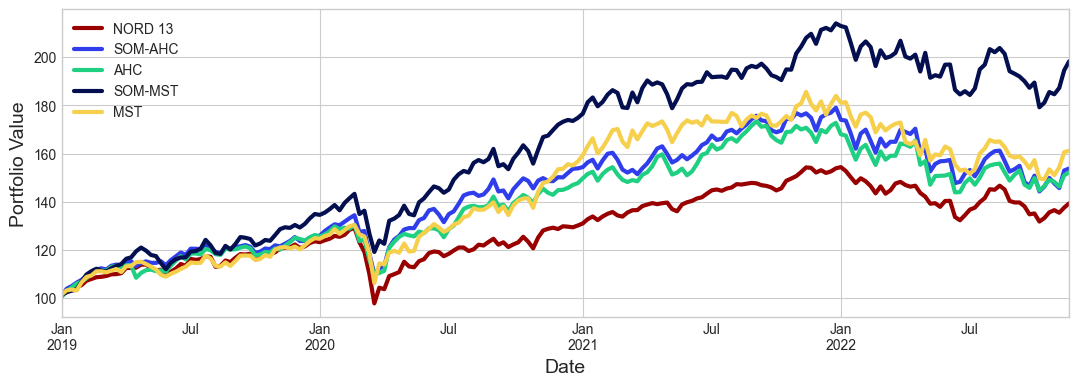

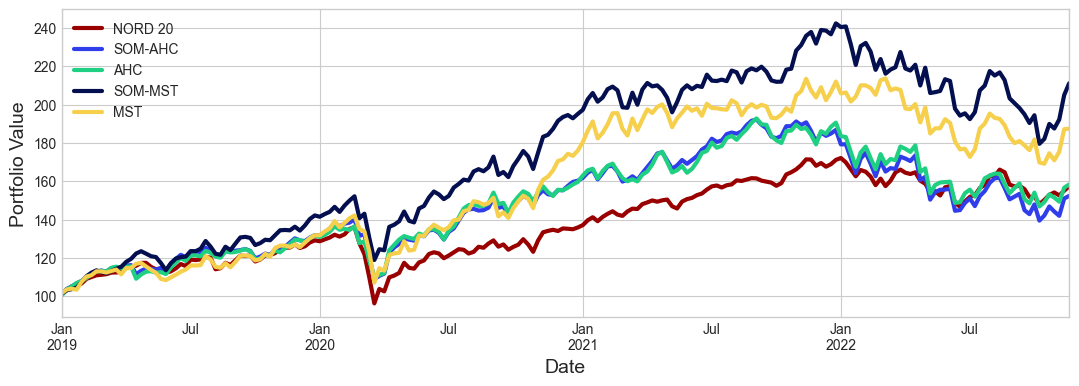

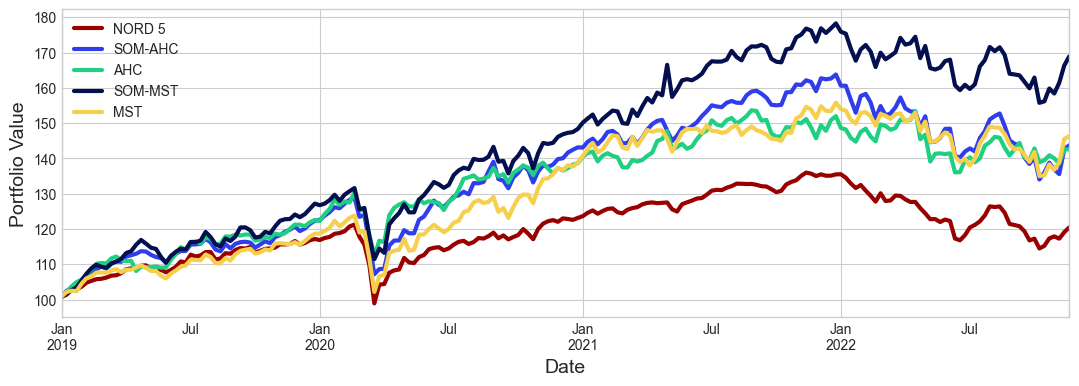

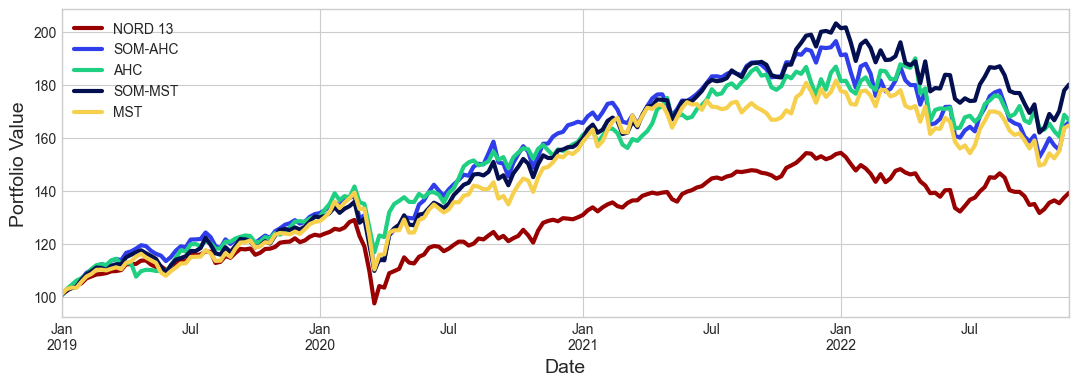

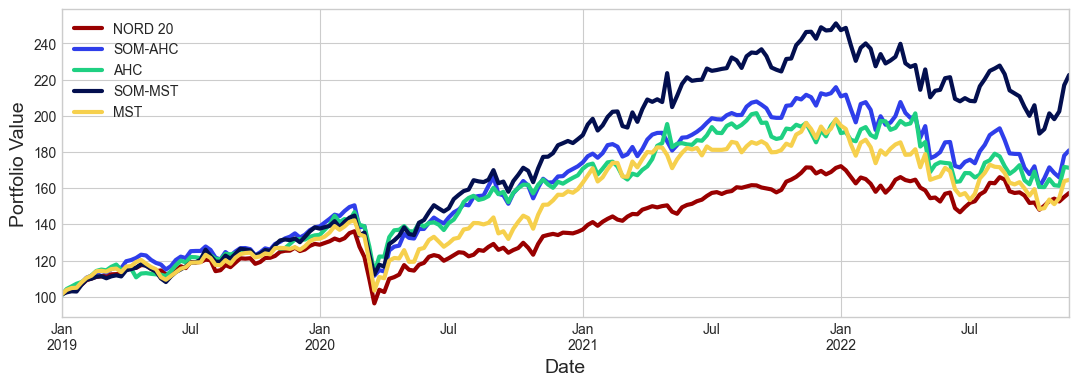

In [17]:
  
    
for size , size_item in portfolio_data.items():
    for level, level_item in size_item.items():

        portfolio_values = pd.DataFrame({
            new_keys[level]:benchmarks[level]["value"]
        }, index = date_index)


        for subset_name, item in level_item.items():
            portfolio_values[new_keys[subset_name]] = item.get("value")

        fig, ax = plt.subplots(figsize=(13,4))
        portfolio_values.plot(ax = ax)
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        #plt.title(f"Portfolio Value Comparison - {level} ({size})")

        
        if size == "Small Subset":
            plt.savefig(fig_path + f'Optport_small_value_{level}.png', bbox_inches='tight')
        else:
            plt.savefig(fig_path + f'Optport_large_value_{level}.png', bbox_inches='tight')
        plt.show()
    
    

In [18]:
scatter_setup = {
    'SOM-Cluster': {"color": colors["DTU Blue"], "marker": {"small": "o", "large": "P"}}, 
    'Cluster': {"color": colors["DTU Green"], "marker": {"small": "o", "large": "P"}}, 
    'SOM-MST': {"color": colors["DTU dBlue"], "marker": {"small": "o", "large": "P"}}, 
    'MST': {"color": colors["DTU Yellow"], "marker": {"small": "o", "large": "P"}}, 
    'nord_5': {"color": colors["DTU Red"], "marker": {"small": "o", "large": "o"}},
    'nord_13': {"color": colors["DTU Red"], "marker": {"small": "o", "large": "o"}},
    'nord_20': {"color": colors["DTU Red"], "marker": {"small": "o", "large": "o"}}
}

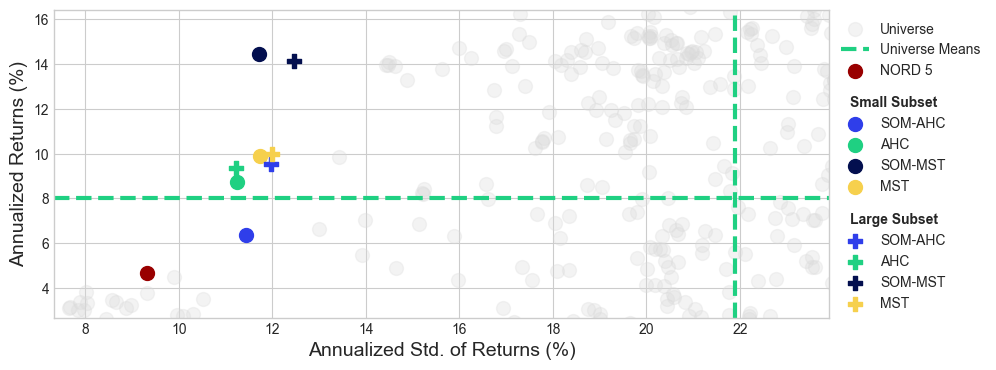

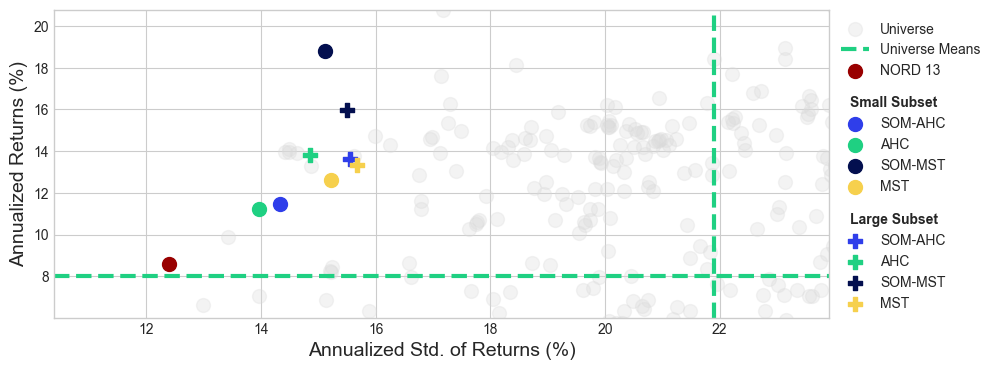

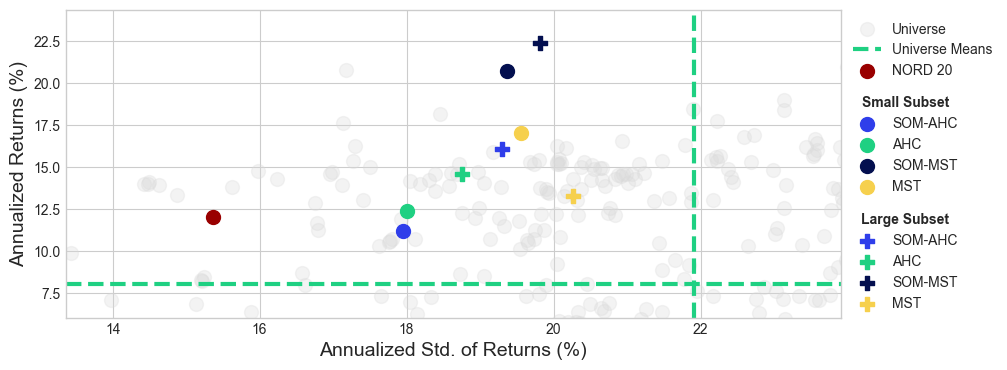

In [19]:

univers_mean_std = get_annualized_std(algo.testDataset, "weekly") * 100
univers_mean_ret = get_annualized_returns(algo.testDataset, "weekly") * 100

levels = list(opt_stats["Small Subset"].keys())

for level in levels:

    fig, ax = plt.subplots(figsize = (10,4))
    plt.scatter(
        univers_mean_std,
        univers_mean_ret,
        color = colors["DTU Gray"],
        label = "Universe",
        alpha = 0.3
    )

    plt.axhline(y = univers_mean_ret.mean(), color = colors["DTU Green"], label = "Universe Means", linestyle = "--")
    plt.axvline(x = univers_mean_std.mean(), color = colors["DTU Green"], linestyle = "--")

    
    scatter_df_small = {}
    for port, item in opt_stats["Small Subset"][level].items():
        if port.startswith("nord"):
            continue
            
        scatter_df_small[port] = {}

        scatter_df_small[port]["std"] = item['Annualized Std (%)']
        scatter_df_small[port]["returns"] = item['Annualized Returns (%)']

    scatter_df_small = pd.DataFrame(scatter_df_small).T
    
    for port in scatter_df_small.index:
         plt.scatter(
            scatter_df_small.loc[port, "std"],
            scatter_df_small.loc[port, "returns"],
            label = new_keys[port], # + " (Small)",
            color = scatter_setup[port]["color"],
            marker = scatter_setup[port]["marker"]["small"]
        )
        
    scatter_df_large = {}
    for port, item in opt_stats["Large Subset"][level].items():
        scatter_df_large[port] = {}

        scatter_df_large[port]["std"] = item['Annualized Std (%)']
        scatter_df_large[port]["returns"] = item['Annualized Returns (%)']

    scatter_df_large = pd.DataFrame(scatter_df_large).T
    
    for port in scatter_df_large.index:
        plt.scatter(
            scatter_df_large.loc[port, "std"],
            scatter_df_large.loc[port, "returns"],
            label = new_keys[port], # if port.startswith("nord") else new_keys[port] + " (Large)",
            color = scatter_setup[port]["color"],
            marker = scatter_setup[port]["marker"]["large"]
        )
        
    plt.ylim(
        bottom = min(scatter_df_small.min()["returns"], scatter_df_large.min()["returns"], univers_mean_ret.mean()) - 2, 
        top = max(scatter_df_small.max()["returns"], scatter_df_large.max()["returns"], univers_mean_ret.mean()) + 2
    )
    plt.xlim(
        left = min(scatter_df_small.min()["std"], scatter_df_large.min()["std"], univers_mean_std.mean()) - 2, 
        right = max(scatter_df_small.max()["std"], scatter_df_large.max()["std"], univers_mean_std.mean()) + 2
    )

    plt.xlabel("Annualized Std. of Returns (%)")
    plt.ylabel("Annualized Returns (%)")
    # plt.title(f"Target: {level}")

    h, l = ax.get_legend_handles_labels()
    plt.legend(
        handles = h[:2] + [h[10]], labels = l[:2] + [l[10]],
        loc='upper left', bbox_to_anchor=(1, 1)
    )
   
    leg_small = mpl.legend.Legend(
        parent = ax, title="Small Subset", title_fontproperties={'weight':'bold'},
        handles = h[2:6], labels = l[2:6],
        loc='upper left', bbox_to_anchor=(1, 0.76)
    )
    ax.add_artist(leg_small)
    
    leg_large = mpl.legend.Legend(
        parent = ax, title="Large Subset", title_fontproperties={'weight':'bold'},
        handles = h[6:10], labels = l[6:10],
        loc='upper left', bbox_to_anchor=(1, 0.38)
    )
    ax.add_artist(leg_large)
    
    plt.savefig(fig_path + f'Optport_comparison_{level}.png', bbox_inches='tight')
    plt.show()